# INSERTING THE NECESSARY PACKAGES

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.filterwarnings('ignore')

## loading the dataset

In [2]:
#Note: aim is not to teach stock price forecasting. It's a very complex domain and I have almost no clue about it. Here I will demonstrate the various techniques which can be used for time-series forecasting
data = pd.read_csv(r"C:\Users\Sinegalatha\Desktop\Kaar\Digiverse Project\dataset\AirPassengers.csv")
print(data.head())

  datesold  price
0  1949-01    112
1  1949-02    118
2  1949-03    132
3  1949-04    129
4  1949-05    121


In [3]:
data

,datesold,price
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [4]:
data1=data
data1['datesold']

0      1949-01
1      1949-02
2      1949-03
3      1949-04
4      1949-05
        ...   
139    1960-08
140    1960-09
141    1960-10
142    1960-11
143    1960-12
Name: datesold, Length: 144, dtype: object

## discriptive analysis of dataset

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datesold  144 non-null    object
 1   price     144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [6]:
data.describe()

,price
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [7]:
data.shape

(144, 2)

In [8]:
data.isna().sum()

datesold    0
price       0
dtype: int64

### there is no null values

## Changing datesold to datetime datatype and setting datatime as index of dataset

In [9]:
data['datesold']=pd.to_datetime(data['datesold'],infer_datetime_format=True)
data.set_index(['datesold'],inplace=True)
data.sort_index(inplace=True),

(None,)

In [10]:
data.head()

,price
datesold,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [11]:
#check datatype of index
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='datesold', length=144, freq=None)

In [12]:
#convert to time series:
ts = data['price']
ts.head(10)

datesold
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: price, dtype: int64

## Checking for stationarity

### Using KPSS test

In [13]:
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(ts)

KPSS Statistic: 1.0521750110135095
p-value: 0.01
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


## ADFULLER TEST

In [14]:
def adfuller_test(timeseries, **kw): 
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
adfuller_test(ts)

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### Both adfuller and kpss test implies that the taken time series data is not stationary

## Visualizing the decomposition of data

### Monthly resampling of data

In [15]:
data1 = data['price'].resample('MS').mean()

In [16]:
print(data1)

datesold
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Freq: MS, Name: price, Length: 144, dtype: int64


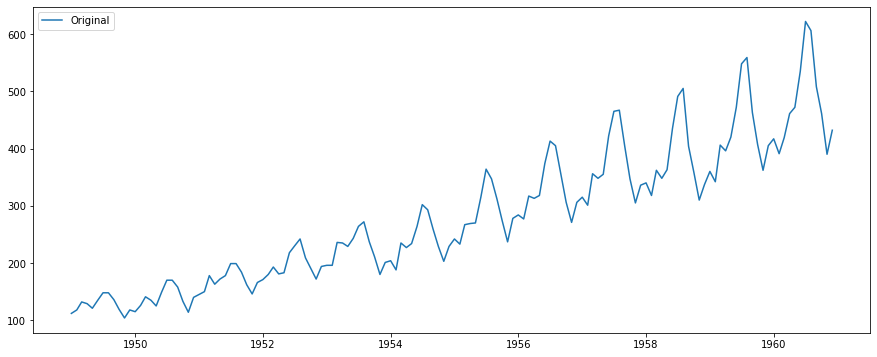

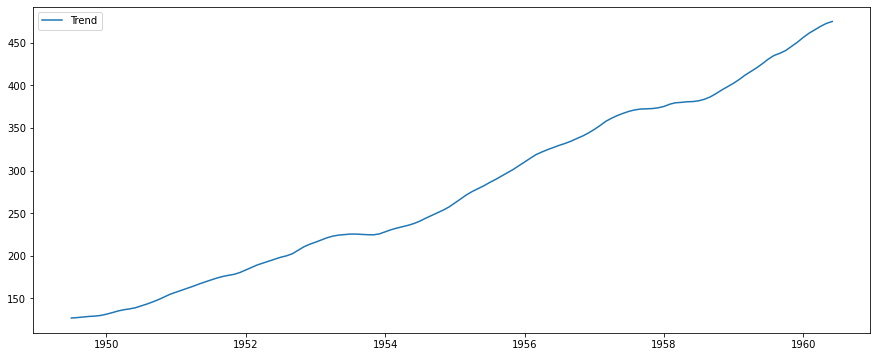

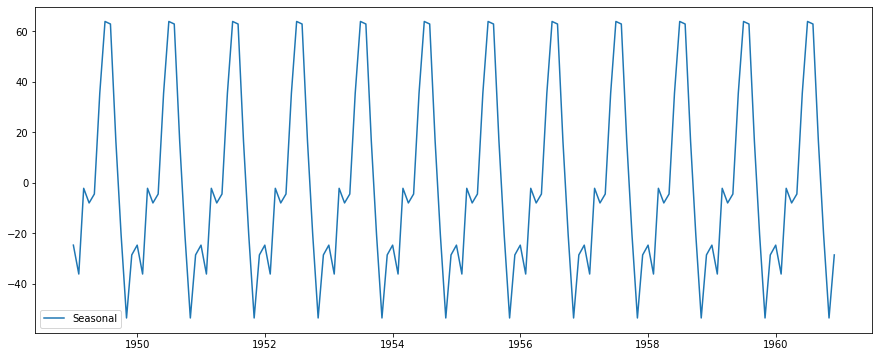

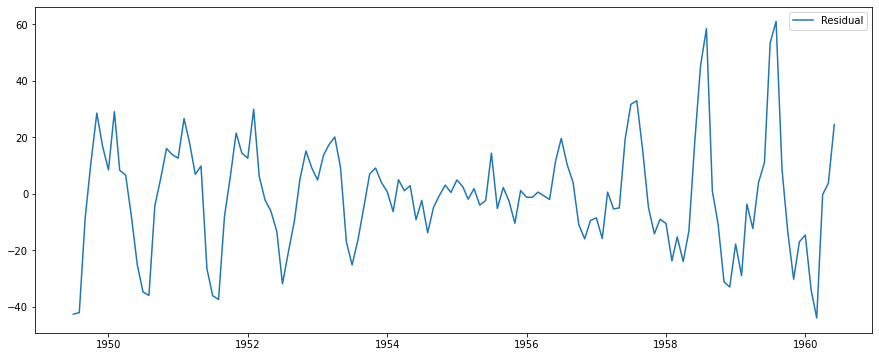

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data1)

plt.plot(data1, label = 'Original')
plt.legend(loc = 'best')

trend = decomposition.trend
plt.show()
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

seasonal = decomposition.seasonal
plt.show()
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')

residual = decomposition.resid
plt.show()
plt.plot(residual, label = 'Residual')
plt.legend(loc='best')

## Making Series stationary

In [18]:
df_sqrt=np.sqrt(ts)
df_diff=df_sqrt.diff().dropna()

In [19]:
df_diff

datesold
1949-02-01    0.279775
1949-03-01    0.626345
1949-04-01   -0.131309
1949-05-01   -0.357817
1949-06-01    0.618950
                ...   
1960-08-01   -0.322861
1960-09-01   -2.078212
1960-10-01   -1.067945
1960-11-01   -1.722493
1960-12-01    1.036192
Name: price, Length: 143, dtype: float64

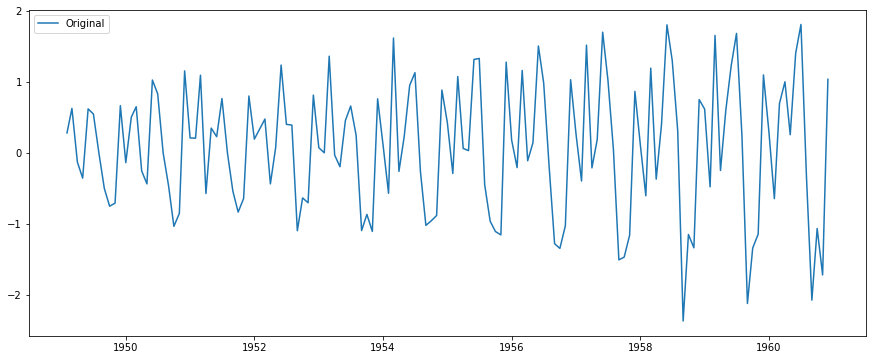

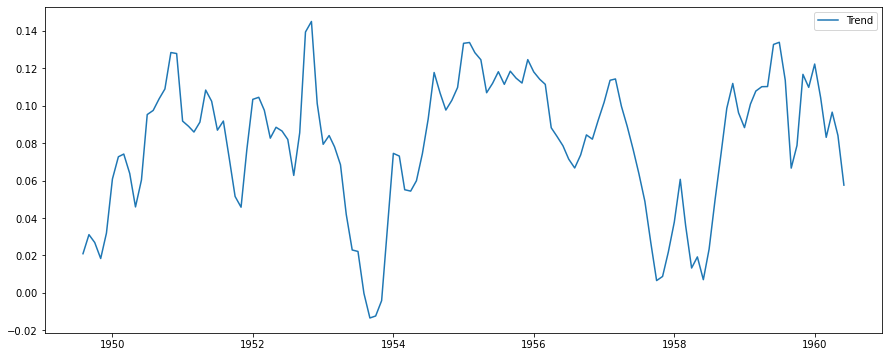

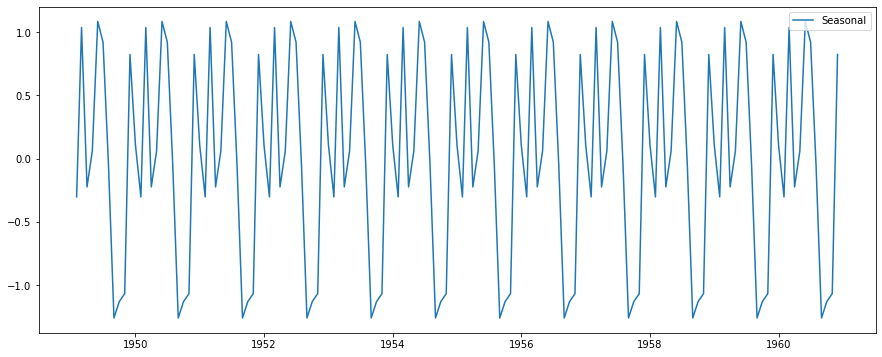

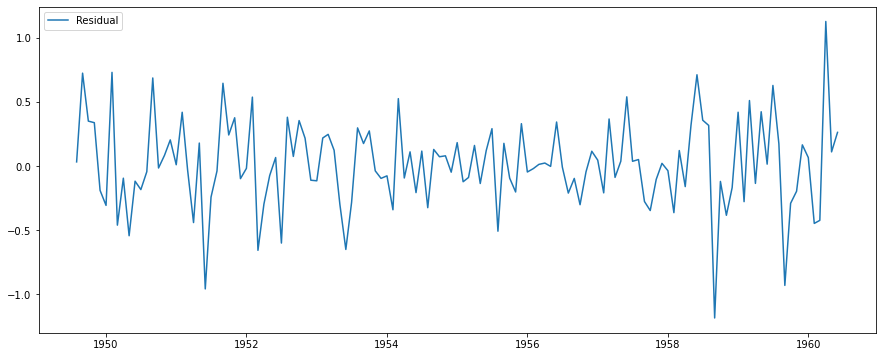

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_diff)

plt.plot(df_diff, label = 'Original')
plt.legend(loc = 'best')

trend = decomposition.trend
plt.show()
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

seasonal = decomposition.seasonal
plt.show()
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')

residual = decomposition.resid
plt.show()
plt.plot(residual, label = 'Residual')
plt.legend(loc='best')

In [21]:
df_diff

datesold
1949-02-01    0.279775
1949-03-01    0.626345
1949-04-01   -0.131309
1949-05-01   -0.357817
1949-06-01    0.618950
                ...   
1960-08-01   -0.322861
1960-09-01   -2.078212
1960-10-01   -1.067945
1960-11-01   -1.722493
1960-12-01    1.036192
Name: price, Length: 143, dtype: float64

## Again check for stationarity

### using KPSS test 

In [22]:
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(df_diff)

KPSS Statistic: 0.06273529242507829
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


### using Adfuller test

In [23]:
def adfuller_test(timeseries, **kw): 
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
adfuller_test(df_diff)

Test Statistic                  -3.186422
p-value                          0.020784
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### Thus now the times series becomes stationary

In [24]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


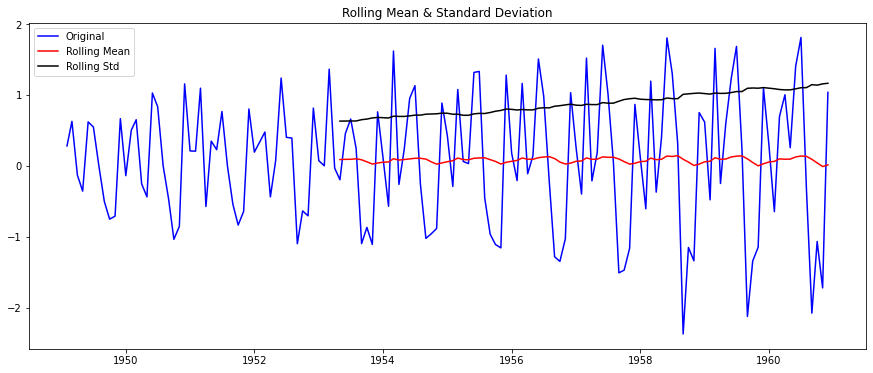

In [25]:
test_stationarity(df_diff)

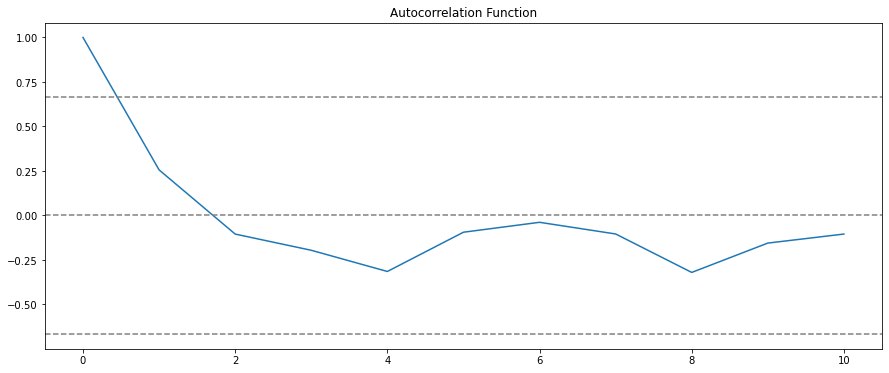

In [26]:
plt.plot(np.arange(0,11), acf(df_diff, nlags = 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(df_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(df_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

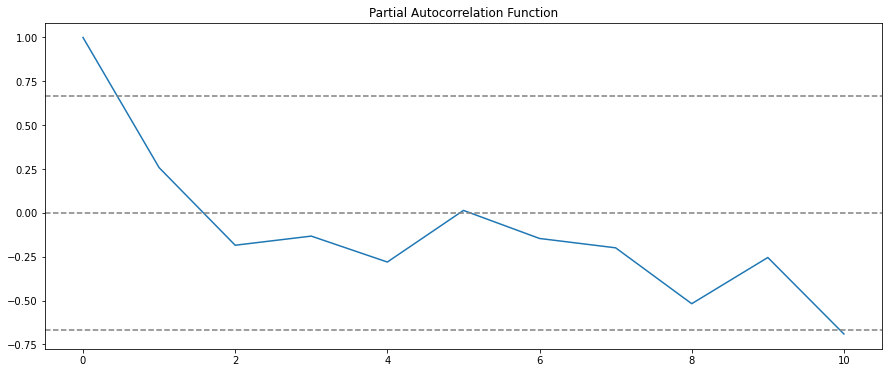

In [27]:
plt.plot(np.arange(0,11), pacf(df_diff, nlags = 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(df_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(df_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

## ARIMA MODEL

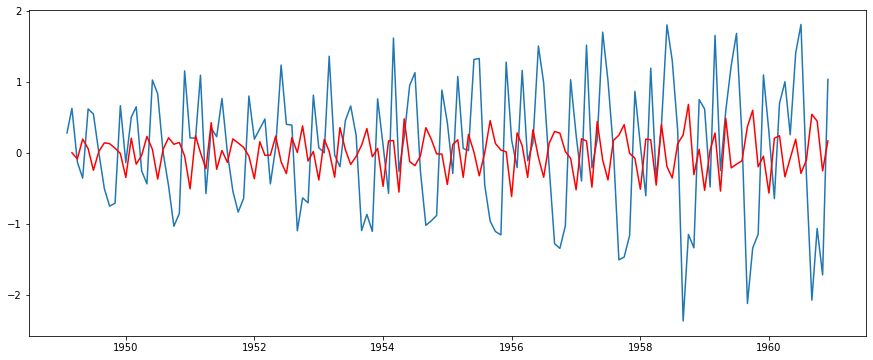

In [28]:
model = ARIMA(df_diff, order=(1, 1, 0))  
results_ARIMA = model.fit()  
plt.plot(df_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

## Making predictions

In [29]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

datesold
1949-03-01    0.000905
1949-04-01   -0.086777
1949-05-01    0.193322
1949-06-01    0.058591
1949-07-01   -0.246634
dtype: float64

In [30]:
df_diff

datesold
1949-02-01    0.279775
1949-03-01    0.626345
1949-04-01   -0.131309
1949-05-01   -0.357817
1949-06-01    0.618950
                ...   
1960-08-01   -0.322861
1960-09-01   -2.078212
1960-10-01   -1.067945
1960-11-01   -1.722493
1960-12-01    1.036192
Name: price, Length: 143, dtype: float64

In [31]:
a=np.concatenate(([df_sqrt[0]], results_ARIMA.fittedvalues)).cumsum()


In [32]:
b=a**2
b

array([112.        , 112.01915095, 110.18980001, 114.28582024,
       115.54197387, 110.30064712, 110.71047431, 113.6715004 ,
       116.43634248, 117.83119722, 117.62176561, 110.19963806,
       114.54581155, 111.12032594, 110.35299726, 115.25183935,
       116.27633613, 108.42463435, 109.47756195, 113.96192078,
       116.53838994, 119.69829928, 118.71630083, 107.88628671,
       112.9509959 , 112.99441674, 108.2780618 , 117.29111358,
       112.30270607, 112.97798735, 110.11779279, 114.25271168,
       117.23570983, 118.8846254 , 117.85032529, 110.04527969,
       113.33140984, 112.56233891, 111.85376095, 116.84078879,
       114.06905697, 107.87835889, 112.35327888, 112.43288523,
       120.61654513, 118.07551272, 118.48000631, 110.26465385,
       114.27659843, 114.68959278, 107.43107296, 114.91531192,
       115.83544422, 112.32318652, 111.25342653, 113.51085248,
       120.90510848, 119.6577774 , 121.02092129, 110.83076359,
       114.38433256, 118.11154203, 106.36915563, 116.46

# VISUALIZING ORIGINAL DATA

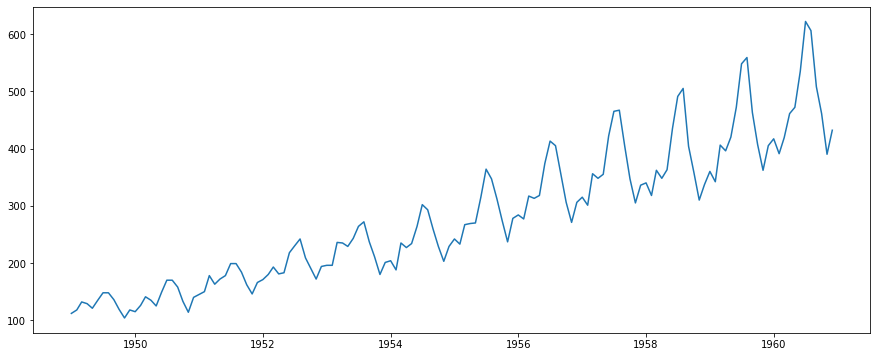

In [33]:
plt.plot(ts)

## VISUALIZING PREDICTING DATA

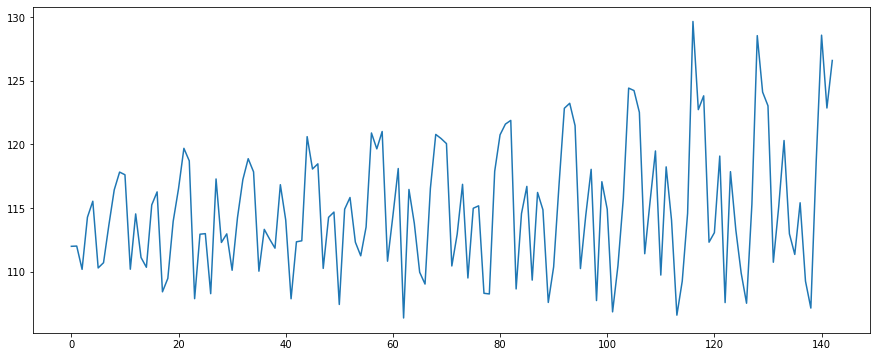

In [34]:
plt.plot(b)

### By comparing the above two graphs, I found that model works good with seasonality but not food with trend

## ARIMA MODEL diff(2)

### Using differentiation method to make the time series stationary

In [35]:
df_shift=ts.diff(2).dropna()

In [36]:
df_shift

datesold
1949-03-01     20.0
1949-04-01     11.0
1949-05-01    -11.0
1949-06-01      6.0
1949-07-01     27.0
              ...  
1960-08-01     71.0
1960-09-01   -114.0
1960-10-01   -145.0
1960-11-01   -118.0
1960-12-01    -29.0
Name: price, Length: 142, dtype: float64

## Check for stationarity

In [37]:
def adfuller_test(timeseries, **kw): 
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
adfuller_test(df_shift)

Test Statistic                  -2.961695
p-value                          0.038630
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### We found that time series is stationary as p value is less than 0.5 in adfuller test

## Building arima model

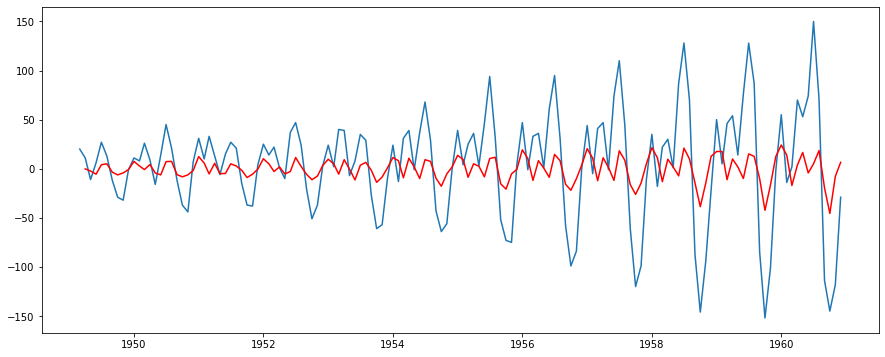

In [38]:
model = ARIMA(df_shift, order=(1, 1, 0))  
results_ARIMA_shift = model.fit()  
plt.plot(df_shift)
plt.plot(results_ARIMA_shift.fittedvalues, color='red')

## Predictions

In [39]:
predictions_ARIMA_diff1 = pd.Series(results_ARIMA_shift.fittedvalues, copy=True)
predictions_ARIMA_diff1.head()

datesold
1949-04-01   -0.162258
1949-05-01   -2.332410
1949-06-01   -5.524626
1949-07-01    4.052021
1949-08-01    5.034241
dtype: float64

In [40]:
df_shift

datesold
1949-03-01     20.0
1949-04-01     11.0
1949-05-01    -11.0
1949-06-01      6.0
1949-07-01     27.0
              ...  
1960-08-01     71.0
1960-09-01   -114.0
1960-10-01   -145.0
1960-11-01   -118.0
1960-12-01    -29.0
Name: price, Length: 142, dtype: float64

## VISUALIZING PREDICTED DATA

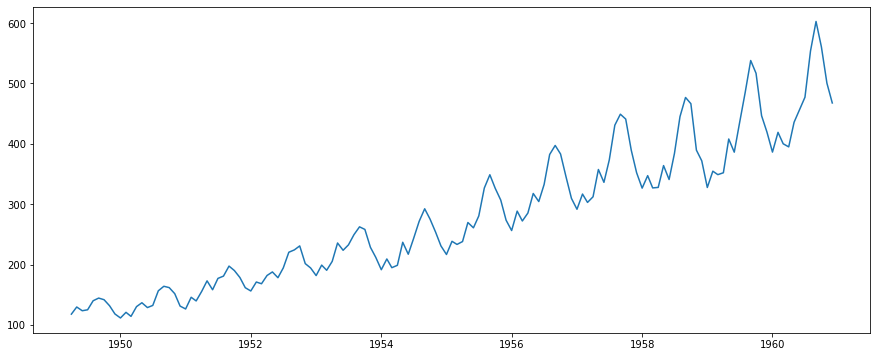

In [41]:
a1=ts.shift(2) + results_ARIMA_shift.fittedvalues.dropna()
plt.plot(a1)

## VISUALIZING ORIGINAL DATA

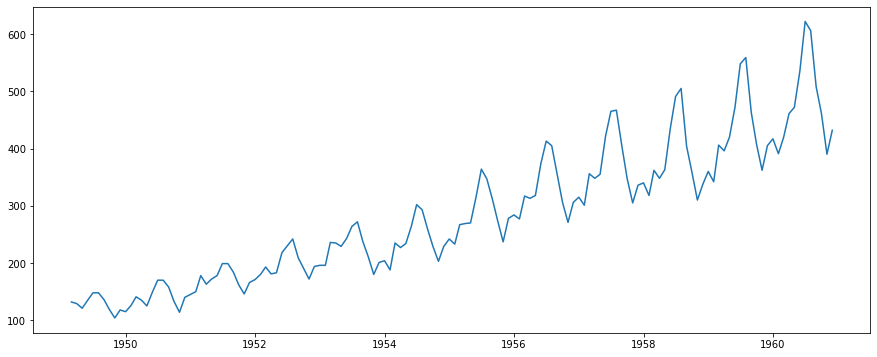

In [42]:
b1=ts.shift(2) + df_shift
plt.plot(b1)

### By comparing above two graphs, we found that the model predicts both trend and seasonality well

In [43]:
ts

datesold
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: price, Length: 144, dtype: int64

In [44]:
a1

datesold
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01    117.837742
1949-05-01    129.667590
                 ...    
1960-08-01    553.539769
1960-09-01    602.478736
1960-10-01    560.449901
1960-11-01    500.265379
1960-12-01    467.507571
Length: 144, dtype: float64

## Building model using SARIMA 

In [45]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df_shift,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.086      4.064      0.000       0.180       0.517
ma.L1         -1.0000    199.105     -0.005      0.996    -391.238     389.238
ar.S.L12      -0.5238      0.353     -1.486      0.137      -1.215       0.167
ma.S.L12       0.4077      0.398      1.024      0.306      -0.373       1.188
sigma2       192.6466   3.83e+04      0.005      0.996    -7.5e+04    7.54e+04


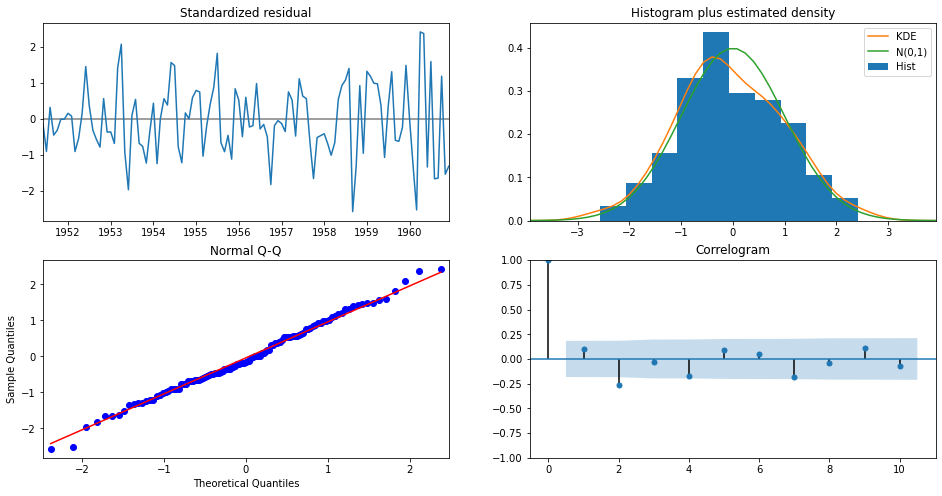

In [46]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

            lower price  upper price
1961-01-01    19.620340    74.243092
1961-02-01   -42.203301    15.785510
1961-03-01   -21.386770    37.046915
1961-04-01    40.303758    98.808299
1961-05-01    19.876879    78.395957
1961-06-01    44.416490   102.939404
1961-07-01   118.165344   176.689445
1961-08-01    44.250101   102.774597
1961-09-01  -139.088883   -80.564252
1961-10-01  -174.730429  -116.205751
1961-11-01  -145.614687   -87.089993
1961-12-01   -53.825433     4.699266
1962-01-01     9.831525    86.119779


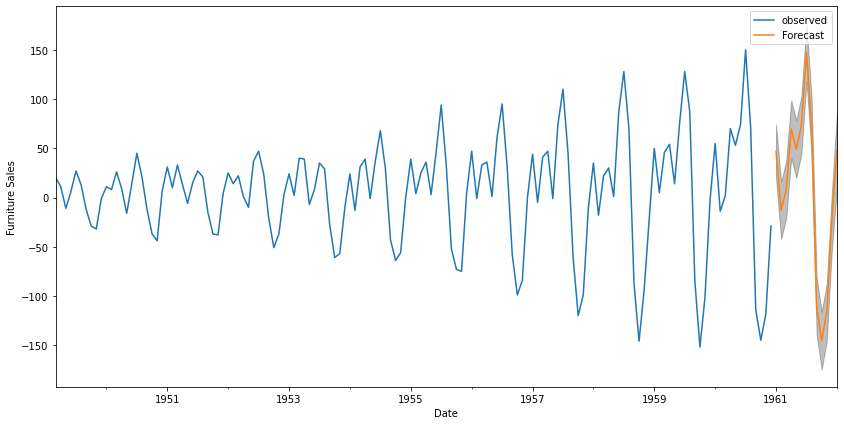

In [47]:
pred_uc = results.get_forecast(steps=13)
pred_ci = pred_uc.conf_int()
ax = df_shift.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
print(pred_ci)
plt.legend()
plt.show()

## Predictions

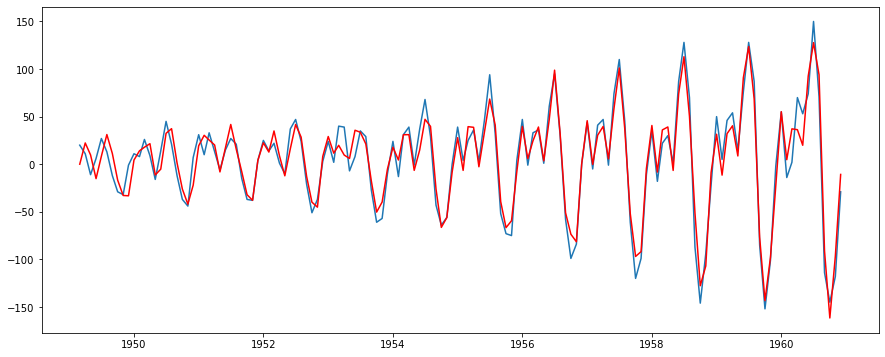

In [48]:
plt.plot(df_shift)
plt.plot(results.fittedvalues, color='red')

### Comparing to above three models, I have found that sarima model forecasts results more accurate (which is interpreted by using the above as the predicted graph is mostly matches with original graph)